# AUTOSAL : Calibration CTD versus bottle sample

IAPSO calibration exercice
GO-SHIP section A02 cruise 45CE20170427 on RV Celtic Explorer from 27 April 2017 to 22 May 2017

Anthony Bosse (anthony.bosse@mio.osupytheas.fr)
Inputs, code and laboratory bottle analysis by Matthieu Labaste (matthieu.labaste@locean-ipsl.upmc.fr)

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import seaborn as sns
import gsw
import ctd
import os
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cmocean as cmo
from tqdm import tqdm
from myfuncs import *
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("paper")

First, we load the AUTOSAL dataset. Each Autosal value reflects an average of 10 values and comes with a std. To gain precision, we keep for each bottle the average of all AUTOSAL measurements keeping only those whose std is not larger than 0.001 psu (approaching the correction we try to estimate).

In [2]:
df_autosal = pd.read_excel("Bottle_Sample_Data/CE17007_Bottle_Data_with_Metadata.xlsx")
df_autosal['sample'] = df_autosal['Cast'].astype(str) +'-'+ df_autosal['Niskin'].astype(str)
df_autosal = df_autosal.loc[df_autosal['Bench Salinity']>0] # remove outliers
df_autosal = df_autosal.loc[df_autosal['Bench Salinity']<40]
df_autosal

,Cast,Date,Time (UTC),Date and Time,Latitude,Longitude,Bot. depth [m],Niskin,Bedford No.,Pres [dbar],Depth [m],Bench Salinity,Winkler DO umol/L,Winkler DO umol/kg,sample
0,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,1,100000,59.658,59.174,33.185,NaN,NaN,CE17007_001-1
4,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,5,100004,45.581,45.212,33.183,NaN,NaN,CE17007_001-5
8,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,9,100008,41.014,40.683,33.134,NaN,NaN,CE17007_001-9
11,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,13,100012,30.034,29.792,33.139,NaN,NaN,CE17007_001-13
14,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,17,100016,21.915,21.739,32.936,NaN,NaN,CE17007_001-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,4,101267,81.557,80.847,35.535,264.274575,257.3,CE17007_066-4
1191,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,5,101268,62.358,61.819,35.536,268.514498,261.5,CE17007_066-5
1192,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,6,101269,40.867,40.515,35.532,273.918058,266.7,CE17007_066-6
1193,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,7,101270,20.572,20.396,35.534,287.391724,279.9,CE17007_066-7


Now, we read data from the .btl files as "db_moose_ge_2023.csv" and get the data from BTL files

In [11]:
df_niskin = pd.read_csv("SBE-profile-data/IAPSO_BTL.csv")
df_niskin['sample'] = [str(x).split('.btl')[0]+'-'+str(xx) for x,xx in zip(df_niskin['BTLFILE'].values,df_niskin['Bottle'].values)]
df_niskin

,Bottle,Month,Day,Year,Latitude,Longitude,Potemp090C,Sal00,Potemp190C,Sal11,...,Sbox0Mm/Kg,OxsolMm/Kg,PrDM,T090C,T190C,C0S/m,C1S/m,Sbeox0V,BTLFILE,sample
0,1,Apr,29,2017,43.5032,50.0048,0.6485,33.1820,0.6492,33.1866,...,254.979,347.00294,59.081,0.6508,0.6514,2.822876,2.823279,1.8517,CE17007_001.btl,CE17007_001-1
1,2,Apr,29,2017,43.5032,50.0048,0.6479,33.1820,0.6485,33.1865,...,255.177,347.00871,59.585,0.6502,0.6508,2.822844,2.823246,1.8522,CE17007_001.btl,CE17007_001-2
2,3,Apr,29,2017,43.5032,50.0048,0.6482,33.1819,0.6487,33.1866,...,254.529,347.00646,59.052,0.6504,0.6509,2.822836,2.823244,1.8511,CE17007_001.btl,CE17007_001-3
3,4,Apr,29,2017,43.5032,50.0048,0.6478,33.1819,0.6486,33.1866,...,254.695,347.00936,59.295,0.6501,0.6509,2.822821,2.823246,1.8501,CE17007_001.btl,CE17007_001-4
4,5,Apr,29,2017,43.5032,50.0048,0.6484,33.1817,0.6492,33.1859,...,245.656,347.00994,45.183,0.6501,0.6509,2.822172,2.822564,1.8053,CE17007_001.btl,CE17007_001-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,4,May,21,2017,49.2000,11.0660,11.6885,35.5363,11.6893,35.5373,...,250.228,263.90765,81.990,11.6990,11.6999,4.029138,4.029320,2.2362,CE17007_066.btl,CE17007_066-4
1227,5,May,21,2017,49.2000,11.0660,11.8272,35.5372,11.8277,35.5384,...,253.158,263.15928,62.447,11.8353,11.8358,4.041601,4.041768,2.2667,CE17007_066.btl,CE17007_066-5
1228,6,May,21,2017,49.2000,11.0660,12.2462,35.5317,12.2430,35.5325,...,258.778,260.91276,40.865,12.2516,12.2484,4.080650,4.080427,2.3233,CE17007_066.btl,CE17007_066-6
1229,7,May,21,2017,49.2000,11.0660,12.5477,35.5348,12.5545,35.5340,...,267.067,259.30904,20.774,12.5505,12.5573,4.109278,4.109852,2.4014,CE17007_066.btl,CE17007_066-7


We can then merge the data frames and make difference between Autosal values and CTD1/2, as well as difference between CTDs.

In [12]:
df = pd.merge(df_autosal, df_niskin, how='inner', left_on = 'sample', right_on='sample')
df

,Cast,Date,Time (UTC),Date and Time,Latitude_x,Longitude_x,Bot. depth [m],Niskin,Bedford No.,Pres [dbar],...,Sbeox0ML/L,Sbox0Mm/Kg,OxsolMm/Kg,PrDM,T090C,T190C,C0S/m,C1S/m,Sbeox0V,BTLFILE
0,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,1,100000,59.658,...,5.8612,254.979,347.00294,59.081,0.6508,0.6514,2.822876,2.823279,1.8517,CE17007_001.btl
1,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,5,100004,45.581,...,5.6469,245.656,347.00994,45.183,0.6501,0.6509,2.822172,2.822564,1.8053,CE17007_001.btl
2,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,9,100008,41.014,...,5.6458,245.617,347.65218,40.774,0.5958,0.5984,2.813046,2.813685,1.8040,CE17007_001.btl
3,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,13,100012,30.034,...,5.9291,257.986,346.72349,29.975,0.7580,0.7597,2.810886,2.811269,1.8689,CE17007_001.btl
4,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,17,100016,21.915,...,6.2532,272.093,345.69981,22.053,0.8779,0.8782,2.819098,2.819364,1.9484,CE17007_001.btl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,4,101267,81.557,...,5.7546,250.228,263.90765,81.990,11.6990,11.6999,4.029138,4.029320,2.2362,CE17007_066.btl
1149,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,5,101268,62.358,...,5.8218,253.158,263.15928,62.447,11.8353,11.8358,4.041601,4.041768,2.2667,CE17007_066.btl
1150,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,6,101269,40.867,...,5.9506,258.778,260.91276,40.865,12.2516,12.2484,4.080650,4.080427,2.3233,CE17007_066.btl
1151,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,7,101270,20.572,...,6.1409,267.067,259.30904,20.774,12.5505,12.5573,4.109278,4.109852,2.4014,CE17007_066.btl


Lets look at the distribution in depth of the bottle sample to choose a lebvel for the analysis

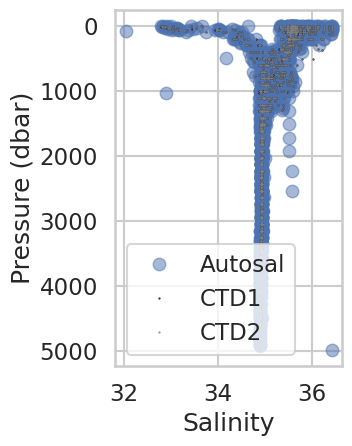

In [13]:
plt.close()
plt.subplot(1,2,1)
plt.plot(df['Bench Salinity'].values,df['PrDM'].values,'o',alpha=0.5,label='Autosal')
plt.plot(df['Sal00'].values,df['PrDM'].values,'.',c='black',alpha=1,ms=1,label='CTD1')
plt.plot(df['Sal11'].values,df['PrDM'].values,'.',c='gray',alpha=1,ms=1,label='CTD2')
plt.gca().invert_yaxis()
plt.gca().grid('on')
plt.xlabel('Salinity')
plt.ylabel('Pressure (dbar)')
plt.legend()
plt.gcf().tight_layout()
plt.gcf().savefig('fig_corS/S_sample_vs_depth', bbox_inches='tight')

Now, we can start to compare the Autosal and bottle with each other. There will be clearly less noise below 1500.

count    1153.000000
mean        0.000298
std         0.114510
min        -1.998200
25%        -0.001600
50%        -0.000200
75%         0.001500
max         1.532000
Name: dS1, dtype: float64
count    1153.000000
mean       -0.000102
std         0.114555
min        -2.000100
25%        -0.001900
50%        -0.000500
75%         0.001000
max         1.533800
Name: dS2, dtype: float64
count    1153.000000
mean        0.000400
std         0.001706
min        -0.028900
25%        -0.000300
50%         0.000300
75%         0.001000
max         0.014600
Name: dS, dtype: float64


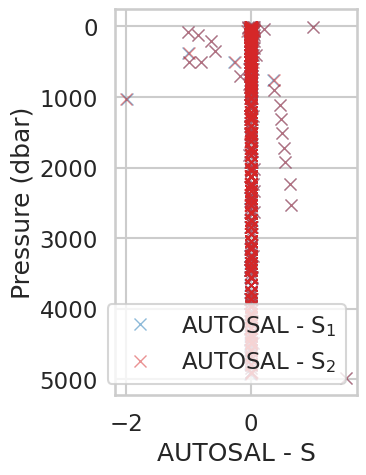

In [14]:
plim = 0# this is the depth limit to use water sample (near surface might be too noisy...)
df["dS1"] = df["Bench Salinity"]- df["Sal00"]
df["dS2"] = df["Bench Salinity"]- df["Sal11"]

df["dS"] = df["Sal11"]- df["Sal00"] # diff between CTD1 and 2

f=plt.subplot(1,2,1)
for var,lab,col in zip(['dS1','dS2'],['AUTOSAL - S$_1$','AUTOSAL - S$_2$'],['tab:blue','tab:red']):
    plt.plot(df[var],df["PrDM"],'x',alpha=0.5,color=col,label=lab)
    plt.grid('on')
plt.tight_layout()
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('AUTOSAL - S')
plt.savefig('fig_corS/distrib_all', bbox_inches='tight')

print(df['dS1'].loc[df['PrDM']>plim].describe())
print(df['dS2'].loc[df['PrDM']>plim].describe())
print(df['dS'].loc[df['PrDM']>plim].describe())

It is clear that there are some outliers that need to be excluded before attempting any correction. We thus filter with IQR Outlier datection method, excluding data $< Q1 - 1.5*IQR$ and $>Q3 + 1.5*IQR$ with $IQR = Q3-Q1$  (function in myfuncs.py) 

/tmp/ipykernel_1162806/3073831215.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  f=plt.subplot(1,2,1)


count    1003.000000
mean       -0.000221
std         0.002137
min        -0.006200
25%        -0.001550
50%        -0.000300
75%         0.000900
max         0.006100
Name: dS1, dtype: float64
count    986.000000
mean      -0.000578
std        0.001995
min       -0.006200
25%       -0.001800
50%       -0.000600
75%        0.000600
max        0.005200
Name: dS2, dtype: float64


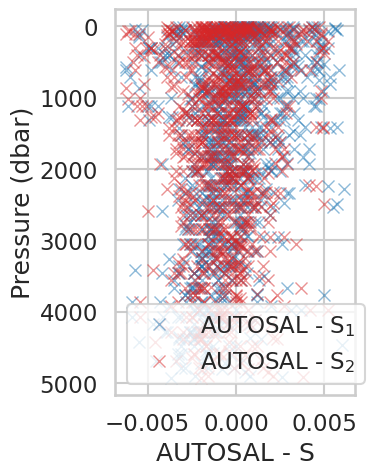

In [15]:
# filter twice the outliers because quite a big spread in distribution
df_dS1fil=filter_df(df.loc[df['PrDM']>plim],'dS1')#.loc[df['Corrected Practical Salinity']<38.485],'dS1')#
df_dS2fil=filter_df(df.loc[df['PrDM']>plim],'dS2')#.loc[df['Corrected Practical Salinity']<38.485],'dS2')#

plt.plot(df_dS1fil["dS1"],df_dS1fil["PrDM"],'o')
plt.plot(df_dS2fil["dS2"],df_dS2fil["PrDM"],'s')


f=plt.subplot(1,2,1)
for var,dff,lab,col in zip(['dS1','dS2'],[df_dS1fil,df_dS2fil],['AUTOSAL - S$_1$','AUTOSAL - S$_2$'],['tab:blue','tab:red']):
    plt.plot(dff[var],dff["PrDM"],'x',alpha=0.5,color=col,label=lab)
    plt.grid('on')
plt.tight_layout()
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.xlabel('AUTOSAL - S')
plt.savefig('fig_corS/distrib_filtered', bbox_inches='tight')

print(df_dS1fil['dS1'].describe())
print(df_dS2fil['dS2'].describe())

The data considered look much better, without outliers and are ready to be used for the analysis.

<Figure size 600x500 with 0 Axes>

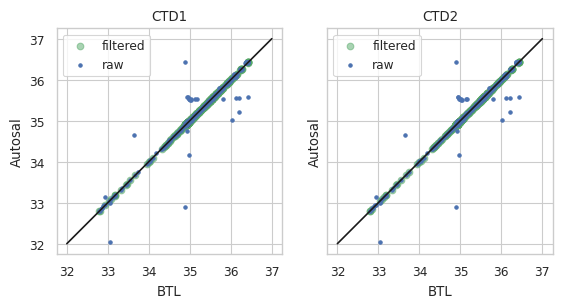

In [16]:
# now make a control plot
plt.close()
fig = plt.figure(dpi=100, figsize=(6, 5))
sns.set(style="whitegrid")
sns.set_context("paper")

f,axs = plt.subplots(1,2,sharey=True)
for i,(dff,var,ax) in enumerate(zip([df_dS1fil,df_dS2fil],['Sal00','Sal11'],axs)):
    ax.plot(np.array([32, 37]),np.array([32, 37]),color='k')
    ax.scatter(dff[var],dff['Bench Salinity'],marker='o',alpha=0.5, label='filtered', color = "g")
    ax.scatter(df[var],df['Bench Salinity'],marker='.', label='raw', color = "b")
    ax.set_title("CTD"+str(i+1))
    ax.set_xlabel('BTL')
    ax.set_ylabel('Autosal')
    ax.legend()
    ax.set_aspect('equal')

f.savefig('fig_corS/_S_fil_outliers', bbox_inches='tight')

First, lets examine the distribution of salinity difference between the Autosal samples and the bottle values recorded by the two CTDs.

sample>0m


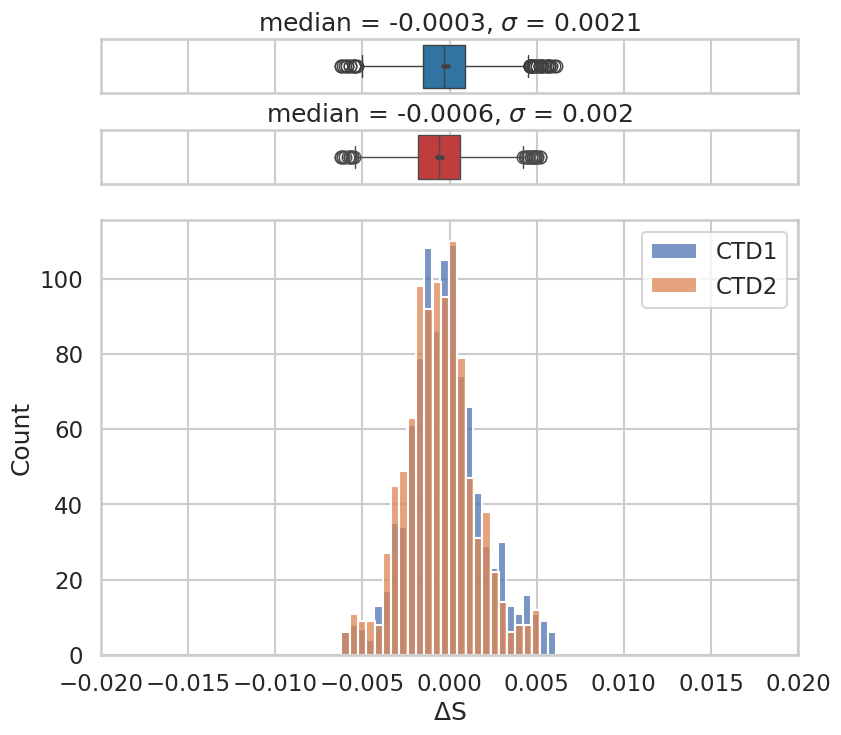

In [17]:
print('sample>'+str(plim)+'m')
plt.close()
fig = histogram_boxplot(df_dS1fil['dS1'].values, df_dS2fil['dS2'].values, leg1 = 'CTD1', leg2 = 'CTD2', xlabel="$\Delta$S", xlim = [-0.02, 0.02])
fig.savefig('fig_corS/dS_IAPSO',bbox_inches='tight')

In [368]:
df_dS1fil

,Cast,Date,Time (UTC),Date and Time,Latitude_x,Longitude_x,Bot. depth [m],Niskin,Bedford No.,Pres [dbar],...,PrDM,T090C,T190C,C0S/m,C1S/m,Sbeox0V,BTLFILE,dS1,dS2,dS
0,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,1,100000,59.658,...,59.081,0.6508,0.6514,2.822876,2.823279,1.8517,CE17007_001.btl,0.0030,-0.0016,0.0046
1,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,5,100004,45.581,...,45.183,0.6501,0.6509,2.822172,2.822564,1.8053,CE17007_001.btl,0.0013,-0.0029,0.0042
7,CE17007_002,2017-04-29,21:15:00,2017-04-29 21:15:00,43.335000,-49.5818,86.8,2,100025,69.126,...,69.159,-0.0573,-0.0567,2.753408,2.753847,2.0145,CE17007_002.btl,0.0016,-0.0035,0.0051
8,CE17007_002,2017-04-29,21:15:00,2017-04-29 21:15:00,43.335000,-49.5818,86.8,3,100026,49.786,...,49.765,0.2698,0.2421,2.772312,2.770978,2.0308,CE17007_002.btl,-0.0013,-0.0135,0.0122
10,CE17007_002,2017-04-29,21:15:00,2017-04-29 21:15:00,43.335000,-49.5818,86.8,5,100028,19.986,...,19.903,1.5782,1.5642,2.868127,2.867460,2.0707,CE17007_002.btl,0.0056,-0.0006,0.0062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,4,101267,81.557,...,81.990,11.6990,11.6999,4.029138,4.029320,2.2362,CE17007_066.btl,-0.0013,-0.0023,0.0010
1149,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,5,101268,62.358,...,62.447,11.8353,11.8358,4.041601,4.041768,2.2667,CE17007_066.btl,-0.0012,-0.0024,0.0012
1150,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,6,101269,40.867,...,40.865,12.2516,12.2484,4.080650,4.080427,2.3233,CE17007_066.btl,0.0003,-0.0005,0.0008
1151,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,7,101270,20.572,...,20.774,12.5505,12.5573,4.109278,4.109852,2.4014,CE17007_066.btl,-0.0008,0.0000,-0.0008


In [369]:
df_dS1fil

,Cast,Date,Time (UTC),Date and Time,Latitude_x,Longitude_x,Bot. depth [m],Niskin,Bedford No.,Pres [dbar],...,PrDM,T090C,T190C,C0S/m,C1S/m,Sbeox0V,BTLFILE,dS1,dS2,dS
0,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,1,100000,59.658,...,59.081,0.6508,0.6514,2.822876,2.823279,1.8517,CE17007_001.btl,0.0030,-0.0016,0.0046
1,CE17007_001,2017-04-29,16:41:00,2017-04-29 16:41:00,43.503000,-50.0048,68.0,5,100004,45.581,...,45.183,0.6501,0.6509,2.822172,2.822564,1.8053,CE17007_001.btl,0.0013,-0.0029,0.0042
7,CE17007_002,2017-04-29,21:15:00,2017-04-29 21:15:00,43.335000,-49.5818,86.8,2,100025,69.126,...,69.159,-0.0573,-0.0567,2.753408,2.753847,2.0145,CE17007_002.btl,0.0016,-0.0035,0.0051
8,CE17007_002,2017-04-29,21:15:00,2017-04-29 21:15:00,43.335000,-49.5818,86.8,3,100026,49.786,...,49.765,0.2698,0.2421,2.772312,2.770978,2.0308,CE17007_002.btl,-0.0013,-0.0135,0.0122
10,CE17007_002,2017-04-29,21:15:00,2017-04-29 21:15:00,43.335000,-49.5818,86.8,5,100028,19.986,...,19.903,1.5782,1.5642,2.868127,2.867460,2.0707,CE17007_002.btl,0.0056,-0.0006,0.0062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,4,101267,81.557,...,81.990,11.6990,11.6999,4.029138,4.029320,2.2362,CE17007_066.btl,-0.0013,-0.0023,0.0010
1149,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,5,101268,62.358,...,62.447,11.8353,11.8358,4.041601,4.041768,2.2667,CE17007_066.btl,-0.0012,-0.0024,0.0012
1150,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,6,101269,40.867,...,40.865,12.2516,12.2484,4.080650,4.080427,2.3233,CE17007_066.btl,0.0003,-0.0005,0.0008
1151,CE17007_066,2017-05-21,03:01:00,2017-05-21 03:01:00,49.199667,-11.0640,182.0,7,101270,20.572,...,20.774,12.5505,12.5573,4.109278,4.109852,2.4014,CE17007_066.btl,-0.0008,0.0000,-0.0008


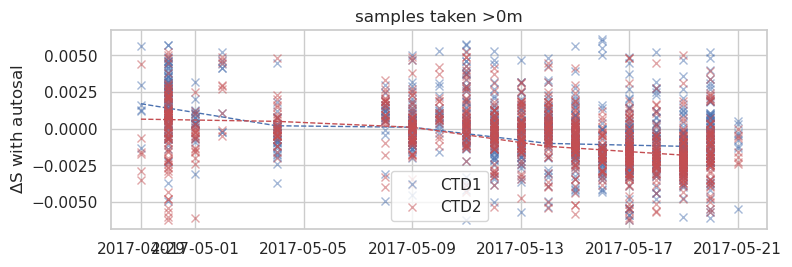

In [370]:
plt.close()
sns.set_context("paper")
sns.set(style="whitegrid")
fig = plt.figure(figsize=(8, 5))

#ax=plt.subplot(2,1,2)
#plt.plot(df_dS1fil['Date'].loc[df['PrDM']>plim],df_dS1fil['Bench Salinity'].loc[df['PrDM']>plim],'x',alpha=0.5,label="Autosal",c="k")
#plt.plot(df_dS1fil['Date'].loc[df['PrDM']>plim],df_dS1fil['Sal00'].loc[df['PrDM']>plim],'o',alpha=0.5,label="CTD1")
#plt.plot(df_dS2fil['Date'].loc[df['PrDM']>plim],df_dS2fil['Sal11'].loc[df['PrDM']>plim],'o',alpha=0.5,label="CTD2")
#plt.ylabel('$S_P$')
#plt.title('samples taken >'+str(plim)+'m')
#plt.legend()


plt.subplot(2,1,1)
plt.plot(df_dS1fil['Date'].loc[df['PrDM']>plim],df_dS1fil['dS1'].loc[df['PrDM']>plim],'x',alpha=0.5,label="CTD1",c="b")
df_tmp = df_dS1fil.set_index('Date and Time')
df_tmp = df_tmp['dS1']
df_tmp = df_tmp.resample('5D').median().interpolate()
plt.plot(df_tmp.index,df_tmp,'--',lw=1,c="b")

plt.plot(df_dS2fil['Date'].loc[df['PrDM']>plim],df_dS2fil['dS2'].loc[df['PrDM']>plim],'x',alpha=0.5,label="CTD2",c="r")
df_tmp = df_dS2fil.set_index('Date and Time')
df_tmp = df_tmp['dS2']
df_tmp = df_tmp.resample('5D').median().interpolate()
plt.plot(df_tmp.index,df_tmp,'--',lw=1,c="r")

plt.ylabel('$\Delta$S with autosal')
plt.title('samples taken >'+str(plim)+'m')
plt.legend()

plt.tight_layout()
fig.savefig('fig_corS/S_sample.png',bbox_inches='tight',dpi=150)

We only consider salinity samples at depths greater than 1200m for stability of the measurements. During leg2 (or more generally after 2021-06-18) $\Delta S$ seems consistent between CTDs, whereas during leg1 the CTD1 is quite variable. CTD2 seems more stable in time. This needs to be checked with actual CTD profiles and their position in space.

## Conductivity correction (Seabird recommandation)

Following the Seabird's best practices for CTD, one should correct the conductivity of CTD1 and CTD2 with reference to Autosal conductivity.

ref : https://www.seabird.com/cms-portals/seabird_com/cms/documents/training/Module10_DataAccuracyFieldCals.pdf

First we recompute conductivity from Autosal salinity

In [371]:
cond_autosal1 = 0.1*gsw.C_from_SP(np.array(df_dS1fil["Bench Salinity"]),np.array(df_dS1fil["T090C"]),np.array(df_dS1fil["PrDM"]))
cond_autosal2 = 0.1*gsw.C_from_SP(np.array(df_dS2fil["Bench Salinity"]),np.array(df_dS2fil["T190C"]),np.array(df_dS2fil["PrDM"]))

In [372]:
df_dS1fil["Autosal C, S/m"] = cond_autosal1
df_dS2fil["Autosal C, S/m"] = cond_autosal2
df_dS1fil['C0S/m']

0       2.822876
1       2.822172
7       2.753408
8       2.772312
10      2.868127
          ...   
1148    4.029138
1149    4.041601
1150    4.080650
1151    4.109278
1152    4.115374
Name: C0S/m, Length: 1003, dtype: float64

Now get slope correction, for whole cruise and each leg.

In [373]:
slope_CTD1,slope_CTD2 = get_slope(df_dS1fil,df_dS2fil,plim)
# 
print("Slope correction for CTD1 | CTD2 : ",'{:0.6f}'.format(slope_CTD1),' | ','{:0.6f}'.format(slope_CTD2))

Slope correction for CTD1 | CTD2 :  0.999995  |  0.999986


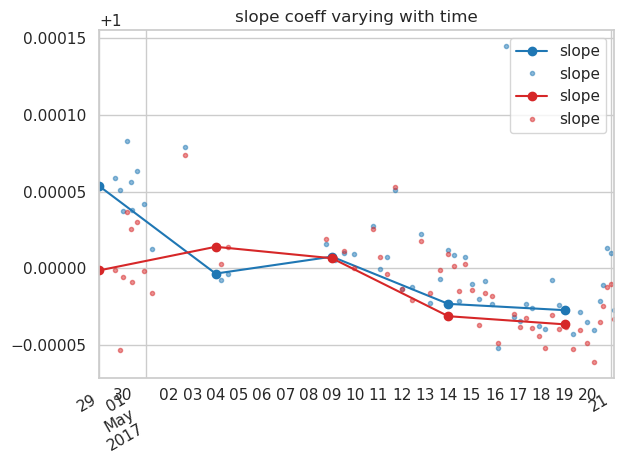

In [375]:
# slope df for CTD1
df_dS1fil['tmp1']=df_dS1fil['Autosal C, S/m'].mul(df_dS1fil['C0S/m'])
df_dS1fil['tmp2']=df_dS1fil['C0S/m'].mul(df_dS1fil['C0S/m'])

tmp1=df_dS1fil[['Cast','tmp1']].groupby('Cast').sum()
tmp2=df_dS1fil[['Cast','tmp2']].groupby('Cast').sum()
tmp3=tmp1.values/tmp2.values

df_slope1 = pd.DataFrame({"slope": tmp3[:,0]},index=df_dS1fil[['Cast','Date and Time']].groupby('Cast').mean().values[:,0])
df_slope11=df_slope1.resample('5D').median().interpolate(method='time')
# slope df for CTD2
df_dS2fil['tmp1']=df_dS2fil['Autosal C, S/m'].mul(df_dS2fil['C1S/m'])
df_dS2fil['tmp2']=df_dS2fil['C1S/m'].mul(df_dS2fil['C1S/m'])

tmp1=df_dS2fil[['Cast','tmp1']].groupby('Cast').sum()
tmp2=df_dS2fil[['Cast','tmp2']].groupby('Cast').sum()
tmp3=tmp1.values/tmp2.values

df_slope2 = pd.DataFrame({"slope": tmp3[:,0]},index=df_dS2fil[['Cast','Date and Time']].groupby('Cast').mean().values[:,0])
df_slope22=df_slope2.resample('5D').median().interpolate(method='time')

plt.close()
fig = plt.figure()#figsize=(8,8))
a=plt.subplot(111)
df_slope11.plot(marker='o',title='slope coeff varying with time',label='slope CTD1',ax=a,color='tab:blue')
df_slope1.plot(marker='.',ax=a,color='tab:blue',alpha=0.5,linestyle='none')

df_slope22.plot(marker='o',label='slope CTD2',ax=a,color='tab:red')
df_slope2.plot(marker='.',ax=a,color='tab:red',alpha=0.5,linestyle='none')

plt.tight_layout()
plt.show()
fig.savefig('fig_corS/slope_varying.png',dpi=150,bbox_inches='tight')

The slopes for CTD1/CTD2 are quite stable (difference 0(0.000001)), we choose to keep one for the whole cruise. 

In [376]:
#df_slope1 = pd.DataFrame({"slope": slope_CTD1},index=df_dS1fil['Date'])
#df_slope2 = pd.DataFrame({"slope": slope_CTD2},index=df_dS2fil['Date'])

The difference in slope between the two legs is not significant, so we use the same for the whole cruise.

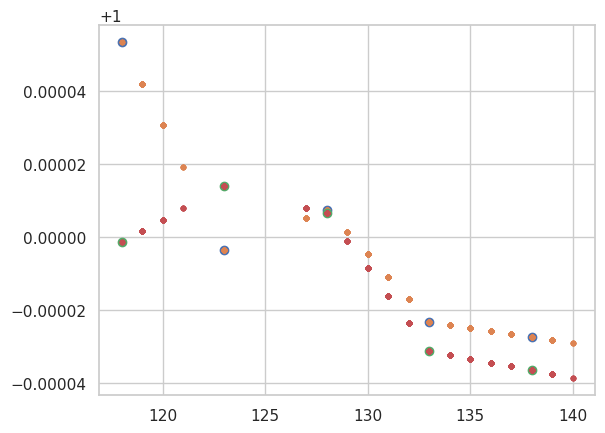

In [377]:
df_dS1fil = cor_cond(df_dS1fil,"C0S/m","Sal00","T090C",df_slope11,'2017-01-01')
df_dS2fil = cor_cond(df_dS2fil,"C1S/m","Sal11","T190C",df_slope22,'2017-01-01')
df_dS1fil["cor dS1"] = df_dS1fil["cor Sal00"] - df_dS1fil["Bench Salinity"]
df_dS2fil["cor dS2"] = df_dS2fil["cor Sal11"] - df_dS2fil["Bench Salinity"]

All cruise:


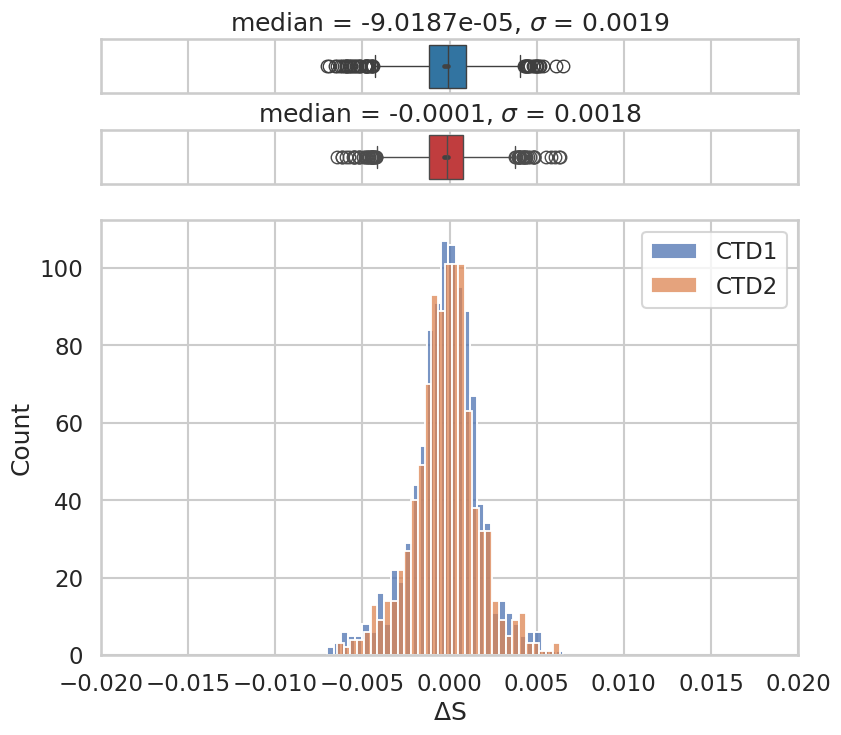

In [379]:
print('All cruise:')
plt.close()
fig = histogram_boxplot(np.array(df_dS1fil['cor dS1']), np.array(df_dS2fil['cor dS2']), leg1 = 'CTD1', leg2 = 'CTD2', xlabel="$\Delta$S", xlim = [-0.02, 0.02])
fig.savefig('fig_corS/adj_dS')
plt.close(fig)

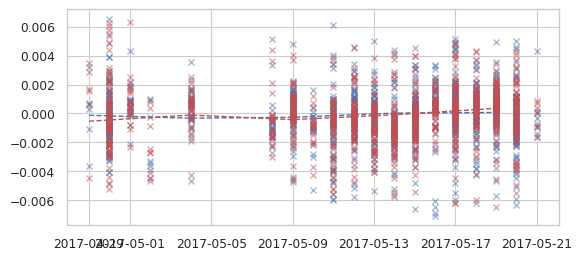

In [380]:
plt.close()
fig = plt.figure(dpi=100, figsize=(6, 5))
sns.set(style="whitegrid")
sns.set_context("paper")

#plt.subplot(2,1,2)
#plt.plot(df_dS1fil['Date'].loc[df['PrDM']>plim],df_dS1fil['Bench Salinity'].loc[df['PrDM']>plim],'x',alpha=0.5,label="Autosal",c="k")
#plt.plot(df_dS1fil['Date'].loc[df['PrDM']>plim],df_dS1fil['cor Sal00'].loc[df['PrDM']>plim],'o',alpha=0.5,label="CTD1")
#plt.plot(df_dS2fil['Date'].loc[df['PrDM']>plim],df_dS2fil['cor Sal11'].loc[df['PrDM']>plim],'o',alpha=0.5,label="CTD2")
#plt.ylabel('$S_P$')
#plt.title('samples taken >'+str(plim)+'m')
#plt.legend()

plt.subplot(2,1,1)
plt.plot(df_dS1fil['Date'].loc[df['PrDM']>plim],df_dS1fil['cor dS1'].loc[df['PrDM']>plim],'x',alpha=0.5,label="CTD1",c="b")
df_tmp = df_dS1fil.set_index('Date and Time')
df_tmp = df_tmp['cor dS1']
df_tmp = df_tmp.resample('5D').median().interpolate()
plt.plot(df_tmp.index,df_tmp,'--',lw=1,c="b")

plt.plot(df_dS2fil['Date'].loc[df['PrDM']>plim],df_dS2fil['cor dS2'].loc[df['PrDM']>plim],'x',alpha=0.5,label="CTD2",c="r")
df_tmp = df_dS2fil.set_index('Date and Time')
df_tmp = df_tmp['cor dS2']
df_tmp = df_tmp.resample('5D').median().interpolate()
plt.plot(df_tmp.index,df_tmp,'--',lw=1,c="r")

plt.tight_layout()
plt.show()
fig.savefig('fig_corS/adj_S_sample.png', bbox_inches='tight')

# Modyfication of XLMCON for reprocessing : Oxygen, T, C

Travail de Dom
SOC =    5.7136E-01
Offset =   -5.0233E-01
E=     3.7649E-02

In [423]:
import xml.etree.ElementTree as ET

lfcon = os.listdir('SBE-profile-data/xmlcon/')
lfcon = [f for f in lfcon if (f.find('test') == -1) & (f.find('XML')!=-1)]
lfcon = np.sort(lfcon)

In [250]:
Soc = 0.57136
Offset = -0.50233
E = 0.037649

In [393]:
pd.to_numeric(df_slope22.index)

Index([1493424000000000000, 1493856000000000000, 1494288000000000000,
       1494720000000000000, 1495152000000000000],
      dtype='int64')

,Date and Time
Cast,
CE17007_001,2017-04-29 16:41:00.000000000
CE17007_002,2017-04-29 21:15:00.000000000
CE17007_003,2017-04-30 00:21:00.000000000
CE17007_004,2017-04-30 04:27:00.000000000
CE17007_005,2017-04-30 08:32:00.000000000
CE17007_006,2017-04-30 10:03:00.000000000
CE17007_007,2017-04-30 14:51:00.000000000
CE17007_008,2017-04-30 22:32:00.000000000
CE17007_009,2017-05-01 06:03:00.000000000


In [428]:
tmp = df[['Cast','Date and Time']].groupby('Cast').mean()
cast_time = tmp.values[:,0]
# check that the cast name sequence in tmp match lfcon
xp = pd.to_numeric(df_slope11.index)
x = pd.to_numeric(cast_time)
yp = df_slope11.slope.values
slope1 = np.interp(x, xp, yp)
# slope2
xp = pd.to_numeric(df_slope22.index)
x = pd.to_numeric(cast_time)
yp = df_slope22.slope.values
slope2 = np.interp(x, xp, yp)

In [431]:
for fcon,sl1,sl2 in zip(lfcon,slope1,slope2):
    # get slope from interp in time
    
    # parsing directly.
    tree = ET.parse('SBE-profile-data/xmlcon//'+fcon)
    root = tree.getroot()

    # modify oxygen coef
    for x in root.iter('CalibrationCoefficients'):
        if x.attrib['equation']=='1':
            for xx in x:
                if xx.tag == 'Soc':
                    xx.text = ' '+str(Soc) #
                if xx.tag == 'offset':
                    xx.text = str(Offset)
                if xx.tag == 'E':
                    xx.text = ' '+str(E)
                x.set('note', 'Soc='+str(Soc)+', offset='+str(Offset)+' and E='+str(E)+' corrected with Winkler samples (D. Lefevre)')


    # temp offset
#    for x in root.iter('TemperatureSensor'):
#        for xx in x:
#            if xx.tag == 'Offset':
#                xx.text = "{:1.5f}".format(Toffset)
#            x.set('note', 'Offset modified (mean CTD1/2, A. Bosse)')
    # cond slope
    #ind = [i for i in range(len(ctd_adj)) if ctd_adj[i]._metadata['name'] == fcon[0:21].lower()]
    lctd = 0
    slopeCTD = [sl1, sl2]
    for x in root.iter('ConductivitySensor'):
        for xx in x:
            if xx.tag == 'Slope':
                tmp = "{:1.6f}".format(slopeCTD[lctd])
                xx.text = tmp
                lctd += 1
        x.set('note', 'Slope (='+str(tmp)+') wrt Autosal samples (A. Bosse)')

    tree.write('SBE-profile-data/XMLCON_adj/'+fcon)

Now it is time to reprocess all profiles!

## Load QCed CTD profiles

In [2]:
# load and check-up plots
lf = os.listdir('SBE-profile-data/cnv/')
lf = [f for f in lf if (f.find('test') == -1) and (f.find('b.') == -1) and (f.find('.cnv')!=-1)]
ctd_repro = [ctd.from_cnv('SBE-profile-data/cnv_adj/'+f) for f in tqdm(lf)]
# store positon and time
time_ctd = [ctd_repro[i]._metadata['time'] for i in range(len(ctd_repro))]
lon_ctd = [ctd_repro[i]._metadata['lon'] for i in range(len(ctd_repro))]
lat_ctd = [ctd_repro[i]._metadata['lat'] for i in range(len(ctd_repro))]
fname_ctd = [ctd_repro[i]._metadata['name'] for i in range(len(ctd_repro))]

100%|██████████| 54/54 [00:44<00:00,  1.22it/s]


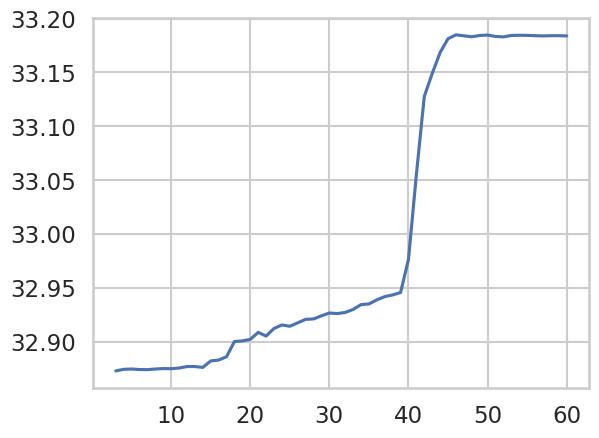

In [39]:
plt.plot(ctd_repro[20]['sal00'].head(100))

In [40]:
cast._metadata

{'name': 'C:\\CTD_data\\2017_Data\\Go-Ship\\CE17007-064',
 'header': '* Sea-Bird SBE 9 Data File:\n* FileName = C:\\CTD_data\\2017_Data\\Go-Ship\\CE17007-064.hdr\n* Software Version Seasave V 7.23.2\n* Temperature SN = 4023\n* Conductivity SN = 3480\n* Number of Bytes Per Scan = 48\n* Number of Voltage Words = 5\n* Number of Scans Averaged by the Deck Unit = 1\n* Append System Time to Every Scan\n* System UpLoad Time = May 20 2017 19:29:57\n* NMEA Latitude = 49 08.38 N\n* NMEA Longitude = 011 49.32 W\n* NMEA UTC (Time) = May 20 2017 19:29:56\n* Store Lat/Lon Data = Append to Every Scan\n* SBE 11plus V 5.2\n* number of scans to average = 1\n* pressure baud rate = 9600\n* NMEA baud rate = 4800\n* surface PAR voltage added to scan\n* A/D offset = 4\n* GPIB address = 1\n* advance primary conductivity  0.073 seconds\n* advance secondary conductivity  0.073 seconds\n* autorun on power up is disabled\n* S>\n** GO-Ship CE17007 Station 64\n* System UTC = May 20 2017 19:29:57\n*END*',
 'config':

In [3]:
ctd_mat = dict([])
pint = np.arange(0,5000,1)

for varr,var_adj in zip(['sal','temp','sig','ox'],
                        ['sal00','t090C','sigma-é00','sbox0Mm/Kg']):
    ctd_mat[varr] = np.empty((len(pint),len(ctd_repro)))
    ctd_mat[varr][:] = np.nan
    ctd_mat[varr+'_adj'] = np.empty((len(pint),len(ctd_repro)))
    ctd_mat[varr+'_adj'][:] = np.nan
    lsta = 0
    print('Interp matrix for '+varr)
    for cast in ctd_repro:
        tmp = interp1d(cast.index.values,cast[var_adj].values,fill_value=np.nan,bounds_error=False)
        ctd_mat[varr+'_adj'][:,lsta] = tmp(pint)
        lsta += 1

Interp matrix for sal
Interp matrix for temp
Interp matrix for sig
Interp matrix for ox


In [43]:
# reshape and get SA, CT
lon_ctd = np.reshape(lon_ctd,(-1,len(ctd_repro)))
lat_ctd = np.reshape(lat_ctd,(-1,len(ctd_repro)))
pint = np.reshape(pint,(len(pint),-1)) 
ctd_mat['SA_adj'] = gsw.SA_from_SP(ctd_mat['sal_adj'],pint,lon_ctd,lat_ctd)
ctd_mat['CT_adj'] = gsw.CT_from_t(ctd_mat['SA_adj'],ctd_mat['temp_adj'],pint)
ctd_mat['PT_adj'] = gsw.pt0_from_t(ctd_mat['SA_adj'],ctd_mat['temp_adj'],pint)
ctd_mat['SA'] = gsw.SA_from_SP(ctd_mat['sal'],pint,lon_ctd,lat_ctd)
ctd_mat['CT'] = gsw.CT_from_t(ctd_mat['SA'],ctd_mat['temp'],pint)
ctd_mat['PT'] = gsw.pt0_from_t(ctd_mat['SA'],ctd_mat['temp'],pint)

/home/abosse/miniconda3/envs/gliderwork/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/abosse/miniconda3/envs/gliderwork/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


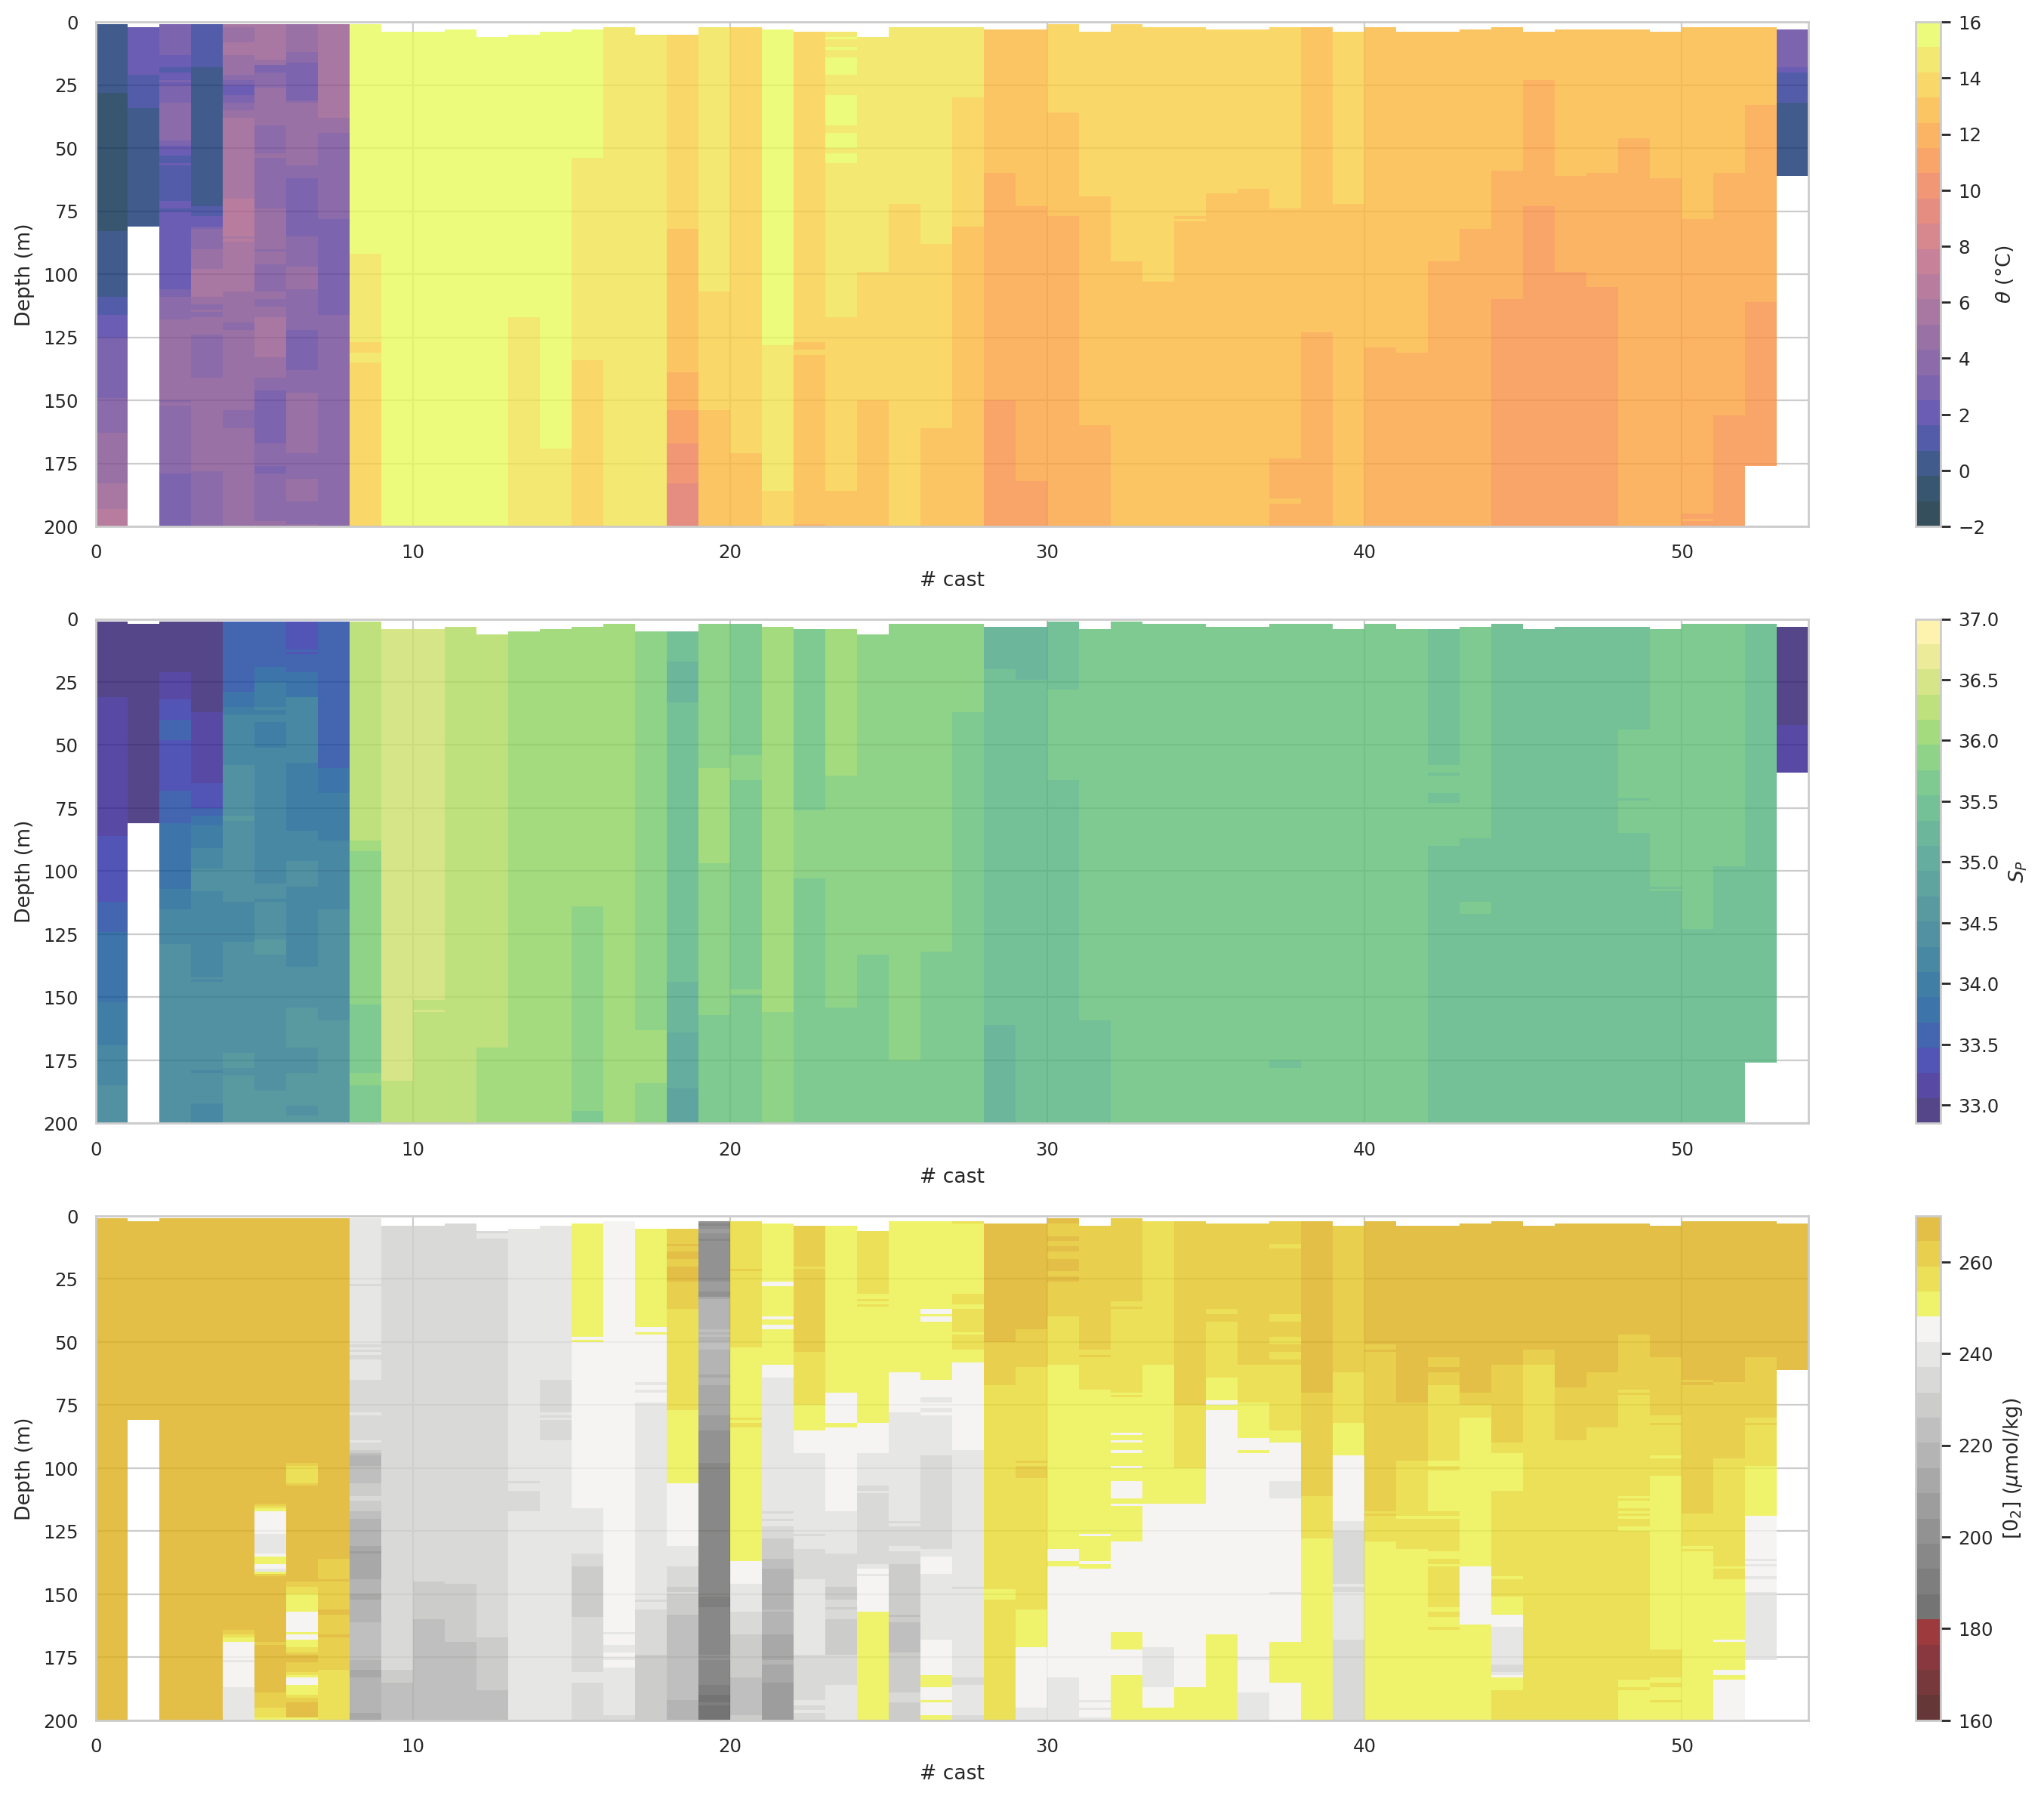

In [4]:
plot_control_section(ctd_mat,zmax = 200, tmin=-2, tmax = 16,smax=36.5)

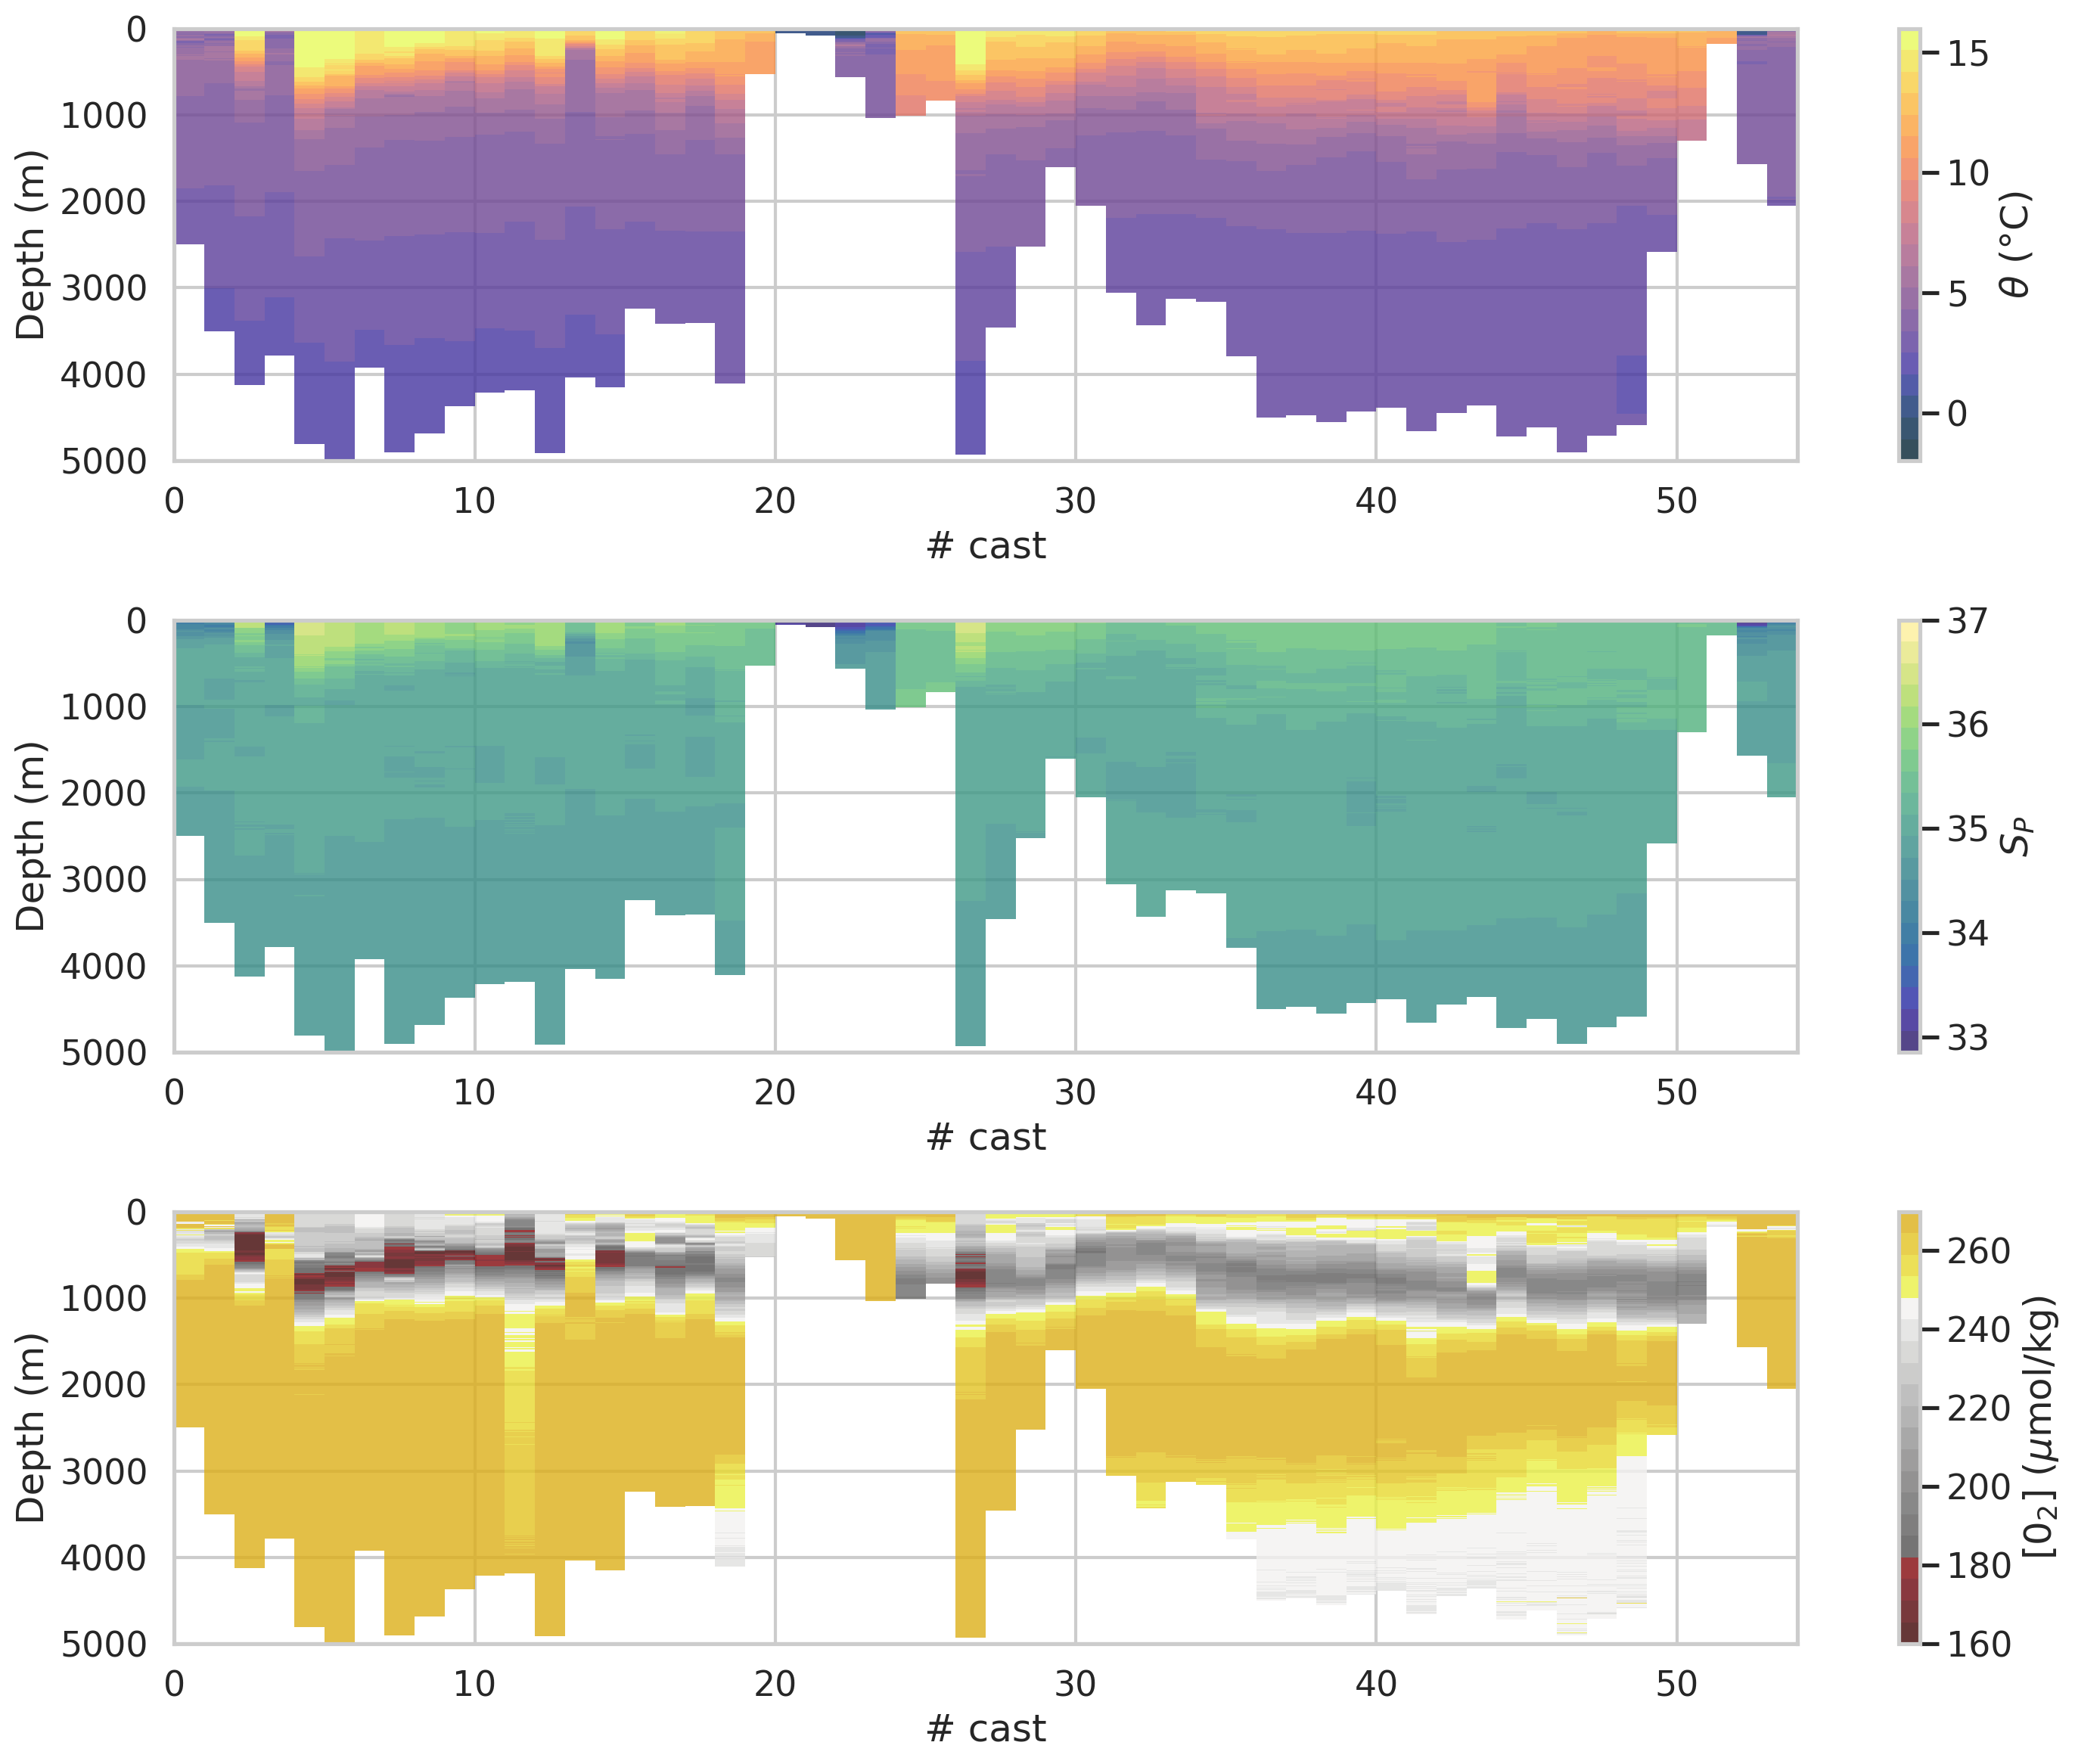

In [48]:
plot_control_section(ctd_mat,zmax = 5000, tmin=-2, tmax = 16,smax=36.5)